# Figure 7 - Airline Tweet Sentiment Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
import xgboost
import numpy as np
import shap
import scipy as sp
from nltk.stem import PorterStemmer
import string
import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the tweet data

This is from http://kaggle.com/crowdflower/twitter-airline-sentiment

In [2]:
raw_data = pd.read_csv("data/tweets.csv")
y = np.zeros(raw_data.shape[0])
mask = raw_data["airline_sentiment"] == "positive"
y[mask] = 1 * raw_data["airline_sentiment_confidence"][mask]
mask = raw_data["airline_sentiment"] == "negative"
y[mask] = -1 * raw_data["airline_sentiment_confidence"][mask]

## Make bag-of-words features

In [3]:
word_counts = {}
ps = PorterStemmer()
translate_table = dict((ord(char), None) for char in string.punctuation) 
for i in range(raw_data.shape[0]):
    words = raw_data["text"][i].split()
    words = [ps.stem(w.lower().translate(translate_table)) for w in words]
    for i in range(len(words)):
        word_counts[words[i]] = word_counts.get(words[i],0)+1

word_inds = {}
ind = 0
for k in word_counts:
    if word_counts[k] >= 10:
        word_inds[k] = ind
        ind += 1
        
X_npy = np.zeros((raw_data.shape[0], len(word_inds)))
word_counts = {}
for i in range(raw_data.shape[0]):
    words = raw_data["text"][i].split()
    words = [ps.stem(w.lower().translate(translate_table)) for w in words]
    for j in range(len(words)):
        if words[j] in word_inds:
            X_npy[i,word_inds[words[j]]] += 1
            
names = ["" for i in range(len(word_inds))]
for k in word_inds:
    names[word_inds[k]] = k
X = pd.DataFrame(data=X_npy, columns=names)

## Create XGBoost data objects

In [4]:
# create a complete dataset
xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)





## Train XGBoost model

In [5]:
# use validation set to choose # of trees
params = {
    "eta": 0.1,
    "max_depth": 30,
    "objective": "reg:linear",
    "base_score": y_train.mean()
}
model_train = xgboost.train(params, xgb_train, 50, evals = [(xgb_test, "test")], verbose_eval=10)

[0]	test-rmse:0.671851
[10]	test-rmse:0.551101
[20]	test-rmse:0.523893
[30]	test-rmse:0.515362
[40]	test-rmse:0.510939
[49]	test-rmse:0.508165


## Compute differences in prediction when perturbing the highest weight feature

In [6]:
preds_orig = []
preds_shap_mod = []
preds_saabas_mod = []
preds_gain_mod = []
L = X_test.shape[0]
shap_sums = [0]
saabas_sums = [0]
gain_sums = [0]
N = X_test.shape[0]
rand_inds = np.array([np.random.randint(N) for i in range(N)])

X_test_shuffle = X_test.iloc[rand_inds,:].copy()
preds_orig = model_train.predict(xgboost.DMatrix(X_test))

# Tree SHAP
tmp = X_test.copy()
shap_values = model_train.predict(xgboost.DMatrix(tmp), pred_contribs=True)
inds = np.argmin(shap_values[:,:-1],1)
for i in range(N):
    tmp.iloc[i,inds[i]] = X_test_shuffle.iloc[i,inds[i]]
preds_shap_mod = model_train.predict(xgboost.DMatrix(tmp))

# Saabas
tmp = X_test.copy()
saabas_values = model_train.predict(xgboost.DMatrix(tmp), pred_contribs=True, approx_contribs=True)
inds = np.argmin(saabas_values[:,:-1],1)
for i in range(N):
    tmp.iloc[i,inds[i]] = X_test_shuffle.iloc[i,inds[i]]
preds_saabas_mod = model_train.predict(xgboost.DMatrix(tmp))

# gain (multiplied by split count to get total gain instead of average gain)
d = model_train.get_score(importance_type="gain")
wd = model_train.get_score(importance_type="weight")
keys = list(d.keys())
vals = [d[k]*wd[k] for k in keys]
gain_ind = np.argmax(vals)
gain_ind = np.where(X_test.columns == keys[gain_ind])[0][0]
print("gain chose", X_test.columns[gain_ind])
tmp = X_test.copy()
for i in range(N):
    if tmp.iloc[i,gain_ind] == 0:
        tmp.iloc[i,gain_ind] = X_test_shuffle.iloc[i,gain_ind]
preds_gain_mod = model_train.predict(xgboost.DMatrix(tmp))

# split count
wd = model_train.get_score(importance_type="weight")
keys = list(d.keys())
vals = [wd[k] for k in keys]
weight_ind = np.argmax(vals)
weight_ind = np.where(X_test.columns == keys[weight_ind])[0][0]
print("weight chose", X_test.columns[weight_ind])
tmp = X_test.copy()
for i in range(N):
    if tmp.iloc[i,weight_ind] == 1:
        tmp.iloc[i,weight_ind] = X_test_shuffle.iloc[i,weight_ind]
preds_weight_mod = model_train.predict(xgboost.DMatrix(tmp))

gain chose thank
weight chose 


### Find the most important feature based on permutation

In [7]:
perm_vals = []
for i in tqdm.tqdm(range(X_test.shape[1])):
    tmp = X_test.copy()
    tmp.iloc[:,i] = X_test_shuffle[:,i]
    preds_tmp = model_train.predict(xgboost.DMatrix(tmp))
    perm_vals.append(np.sqrt(np.mean((y_test-preds_tmp)**2)))
print("permutation chose", X_test.columns[np.argmax(perm_vals)])

100%|██████████| 1686/1686 [07:01<00:00,  4.19it/s]

permutation chose thank


In [353]:
saabas_sums = [0]
shap_sums = [0]
gain_sums = [0]
weight_sums = [0]
for i in range(N):
    saabas_sums.append(saabas_sums[-1]+preds_saabas_mod[i]-preds_orig[i])
    shap_sums.append(shap_sums[-1]+preds_shap_mod[i]-preds_orig[i])
    gain_sums.append(gain_sums[-1]+preds_gain_mod[i]-preds_orig[i])
    weight_sums.append(weight_sums[-1]+preds_weight_mod[i]-preds_orig[i])

## Plot the perturbation results

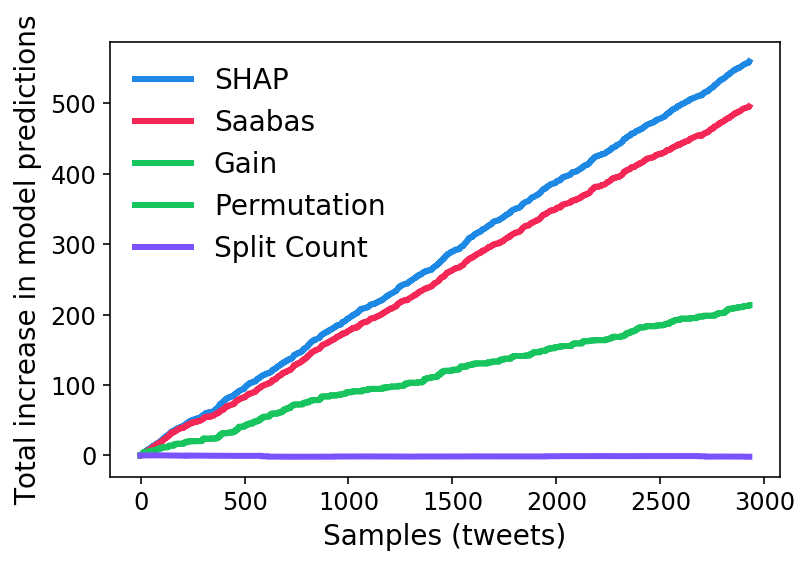

In [364]:
pl.plot(shap_sums, label="SHAP", color=(30/255, 136/255, 229/255), linewidth=3)
pl.plot(saabas_sums, label="Saabas", color=(245/255, 39/255, 87/255), linewidth=3)
pl.plot(gain_sums, label="Gain", color=(24/255, 196/255, 93/255), linewidth=3)
pl.plot(gain_sums, label="Permutation", color=(24/255, 196/255, 93/255), linewidth=3)
pl.plot(weight_sums, label="Split Count", color=(124/255, 82/255, 255/255), linewidth=3)
pl.legend(frameon=False, fontsize=14)
pl.ylabel("Total increase in model predictions", fontsize=14)
pl.xlabel("Samples (tweets)", fontsize=14)
pl.gca().tick_params(axis='x', labelsize=12)
pl.gca().tick_params(axis='y', labelsize=12)
#pl.savefig("data/sentiment_perturbation.pdf")

## Plot the summary

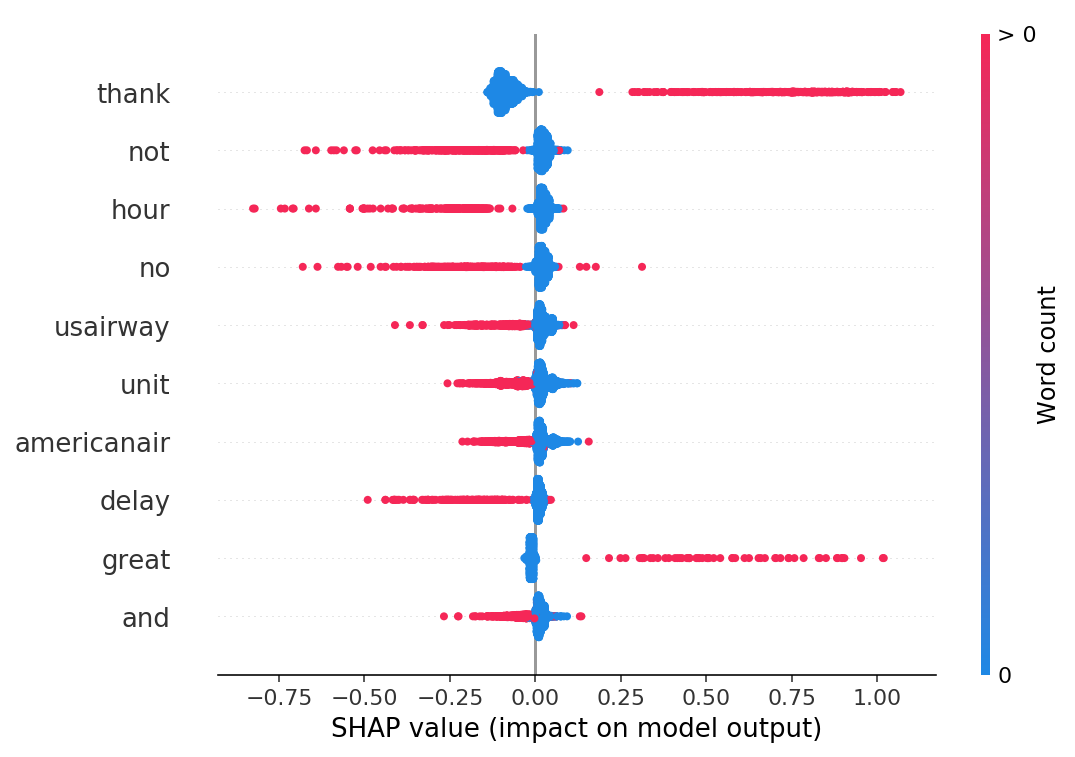

In [355]:
shap.summary_plot(shap_values, X_test, max_display=10, show=False, color_bar=False)
cb = pl.colorbar(ticks=[0,1], aspect=1000)
cb.set_ticklabels(["0", "> 0"])
cb.set_label("Word count", size=12, labelpad=0)
cb.ax.tick_params(labelsize=11, length=0)
cb.set_alpha(1)
cb.outline.set_visible(False)
bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
cb.ax.set_aspect((bbox.height-0.9)*20)
#pl.savefig("data/sentiment_summary.pdf")

In [321]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=50).fit_transform(shap_values[:,:-1])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_pca50)

In [321]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca2 = PCA(n_components=2).fit_transform(shap_values[:,:-1])

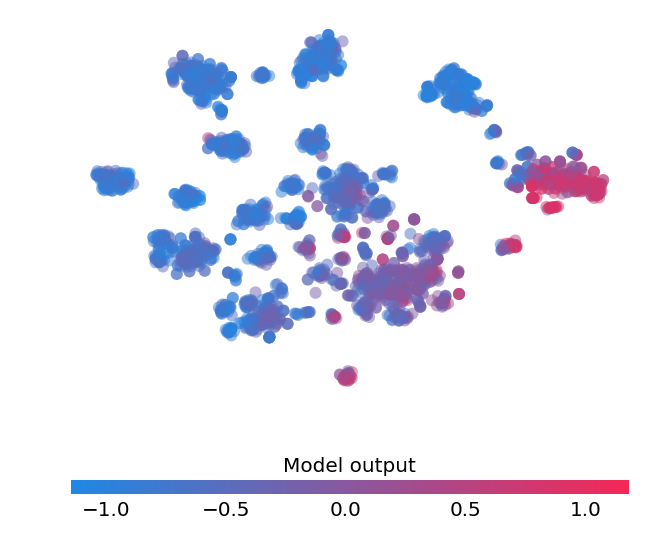

In [337]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=np.sum(shap_values,axis=1), linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

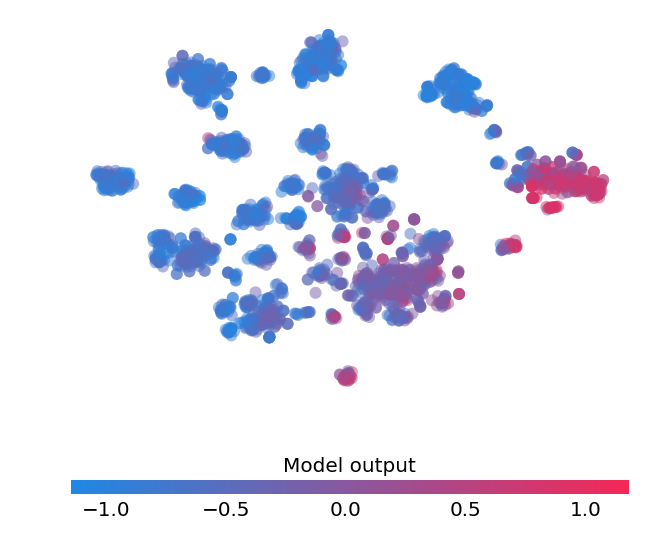

In [337]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=np.sum(shap_values,axis=1), linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

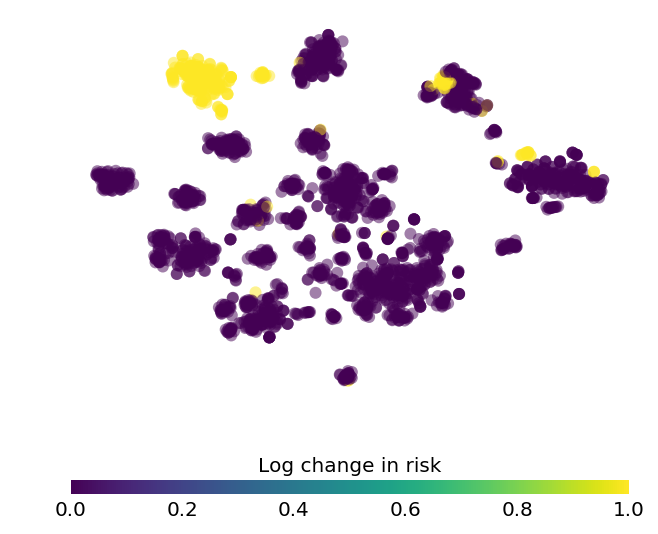

In [343]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X_test["not"] > 0, linewidth=0, alpha=0.5)
cb = pl.colorbar(label="Log change in risk", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

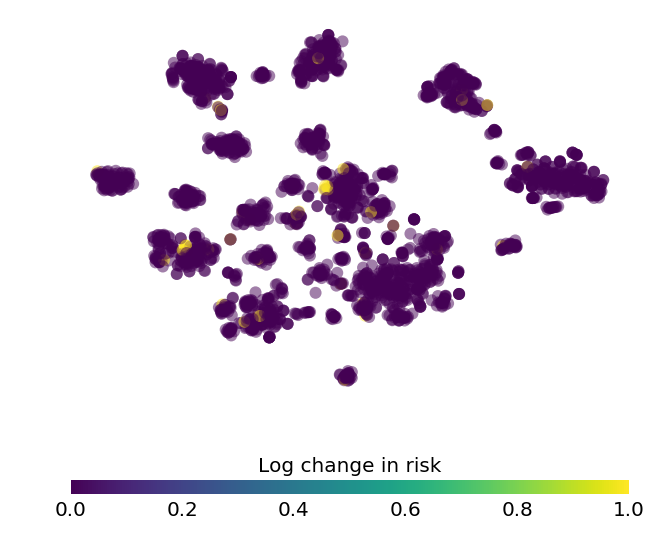

In [334]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X_test["never"], linewidth=0, alpha=0.5)
cb = pl.colorbar(label="Log change in risk", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

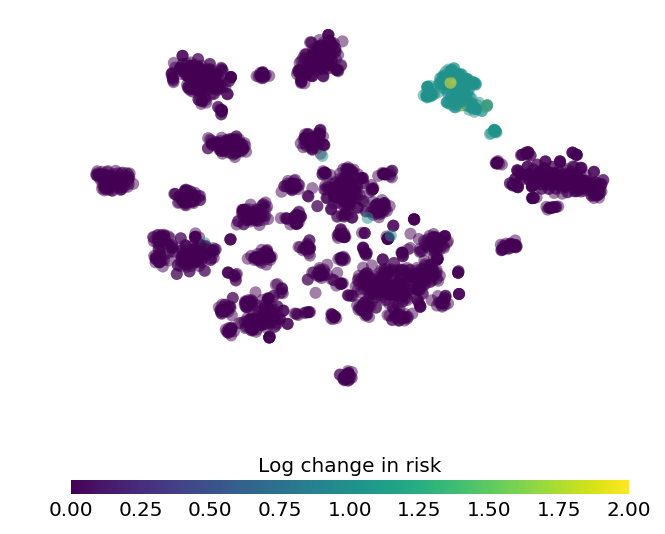

In [325]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X_test["hour"], linewidth=0, alpha=0.5)
cb = pl.colorbar(label="Log change in risk", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

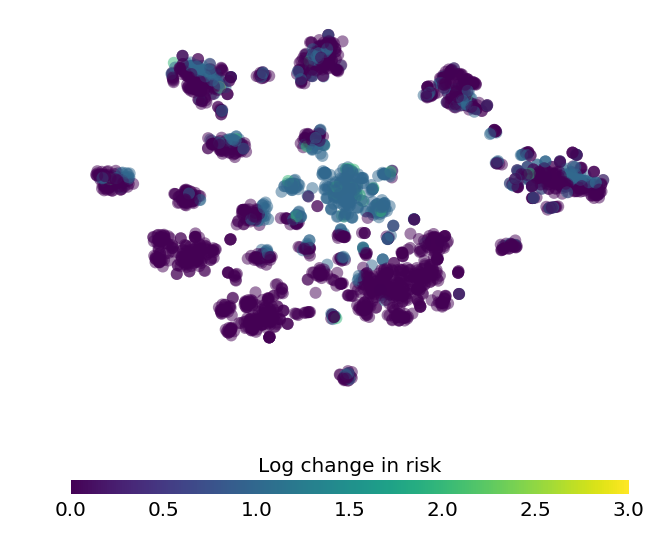

In [331]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X_test["unit"], linewidth=0, alpha=0.5)
cb = pl.colorbar(label="Log change in risk", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

In [209]:
preds_orig = []
preds_shap_mod = []
preds_saabas_mod = []
preds_gain_mod = []
L = X_test.shape[0]
shap_sums = [0]
saabas_sums = [0]
gain_sums = [0]
for i in tqdm.tqdm(range(150)):
    rand_ind = np.random.randint(X_test.shape[0])
    tmp = X_test.iloc[i:i+1,:].copy()
    #print()
    preds_orig.append(model_train.predict(xgboost.DMatrix(tmp))[0])
    
    shap_values_tmp = model_train.predict(xgboost.DMatrix(tmp), pred_contribs=True)
    ind = np.argmin(shap_values_tmp[0,:-1])
    #print(X_test.columns[ind], "==", tmp.iloc[0,ind], "-->", shap_values_tmp[0,ind])
#     if tmp.iloc[0,ind] == 0:
#         tmp.iloc[0,ind] = 1
#     else:
#         tmp.iloc[0,ind] = 0
    tmp.iloc[0,ind] = X_test.iloc[rand_ind,ind]
    preds_shap_mod.append(model_train.predict(xgboost.DMatrix(tmp))[0])
    #print(preds_shap_mod[-1]-preds_orig[-1])
    shap_sums.append(preds_shap_mod[-1]-preds_orig[-1]+shap_sums[-1])
    
    tmp = X_test.iloc[i:i+1,:].copy()
    saabas_values_tmp = model_train.predict(xgboost.DMatrix(tmp), pred_contribs=True, approx_contribs=True)
    ind = np.argmin(saabas_values_tmp[0,:-1])
    #print(X_test.columns[ind], "==", tmp.iloc[0,ind], "-->", saabas_values_tmp[0,ind])
#     if tmp.iloc[0,ind] == 0:
#         tmp.iloc[0,ind] = 1
#     else:
#         tmp.iloc[0,ind] = 0
    tmp.iloc[0,ind] = X_test.iloc[rand_ind,ind]
    preds_saabas_mod.append(model_train.predict(xgboost.DMatrix(tmp))[0])
    #print(preds_saabas_mod[-1]-preds_orig[-1])
    saabas_sums.append(preds_saabas_mod[-1]-preds_orig[-1]+saabas_sums[-1])
    
    tmp = X_test.iloc[i:i+1,:].copy()
    ind = gain_ind
#     if tmp.iloc[0,ind] == 0:
#         tmp.iloc[0,ind] = 1
#     else:
#         tmp.iloc[0,ind] = 0
    if tmp.iloc[0,ind] == 0:
        tmp.iloc[0,ind] = X_test.iloc[rand_ind,ind]
    preds_gain_mod.append(model_train.predict(xgboost.DMatrix(tmp))[0])
    #print(preds_saabas_mod[-1]-preds_orig[-1])
    gain_sums.append(preds_gain_mod[-1]-preds_orig[-1]+gain_sums[-1])
    
preds_orig = np.array(preds_orig)
preds_shap_mod = np.array(preds_shap_mod)
preds_saabas_mod = np.array(preds_saabas_mod)
preds_gain_mod = np.array(preds_gain_mod)
    #print(X_test.columns[ind])

100%|██████████| 150/150 [00:12<00:00, 11.73it/s]


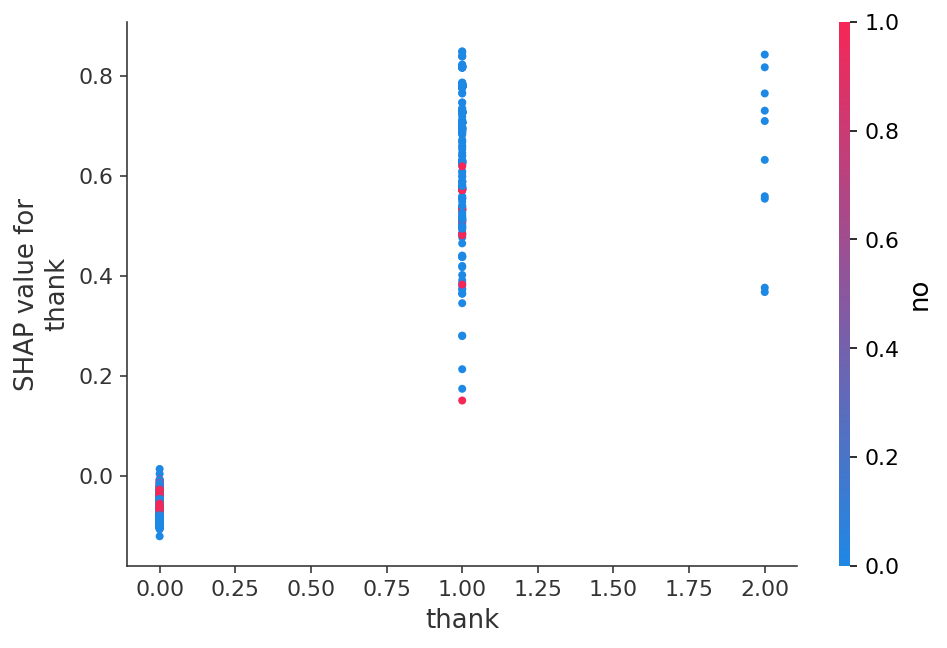

In [23]:
shap.dependence_plot("thank", shap_values, X_test)

In [32]:
shap_interaction_values = model_train.predict(xgboost.DMatrix(X_test.iloc[:1000,:]), pred_interactions=True)

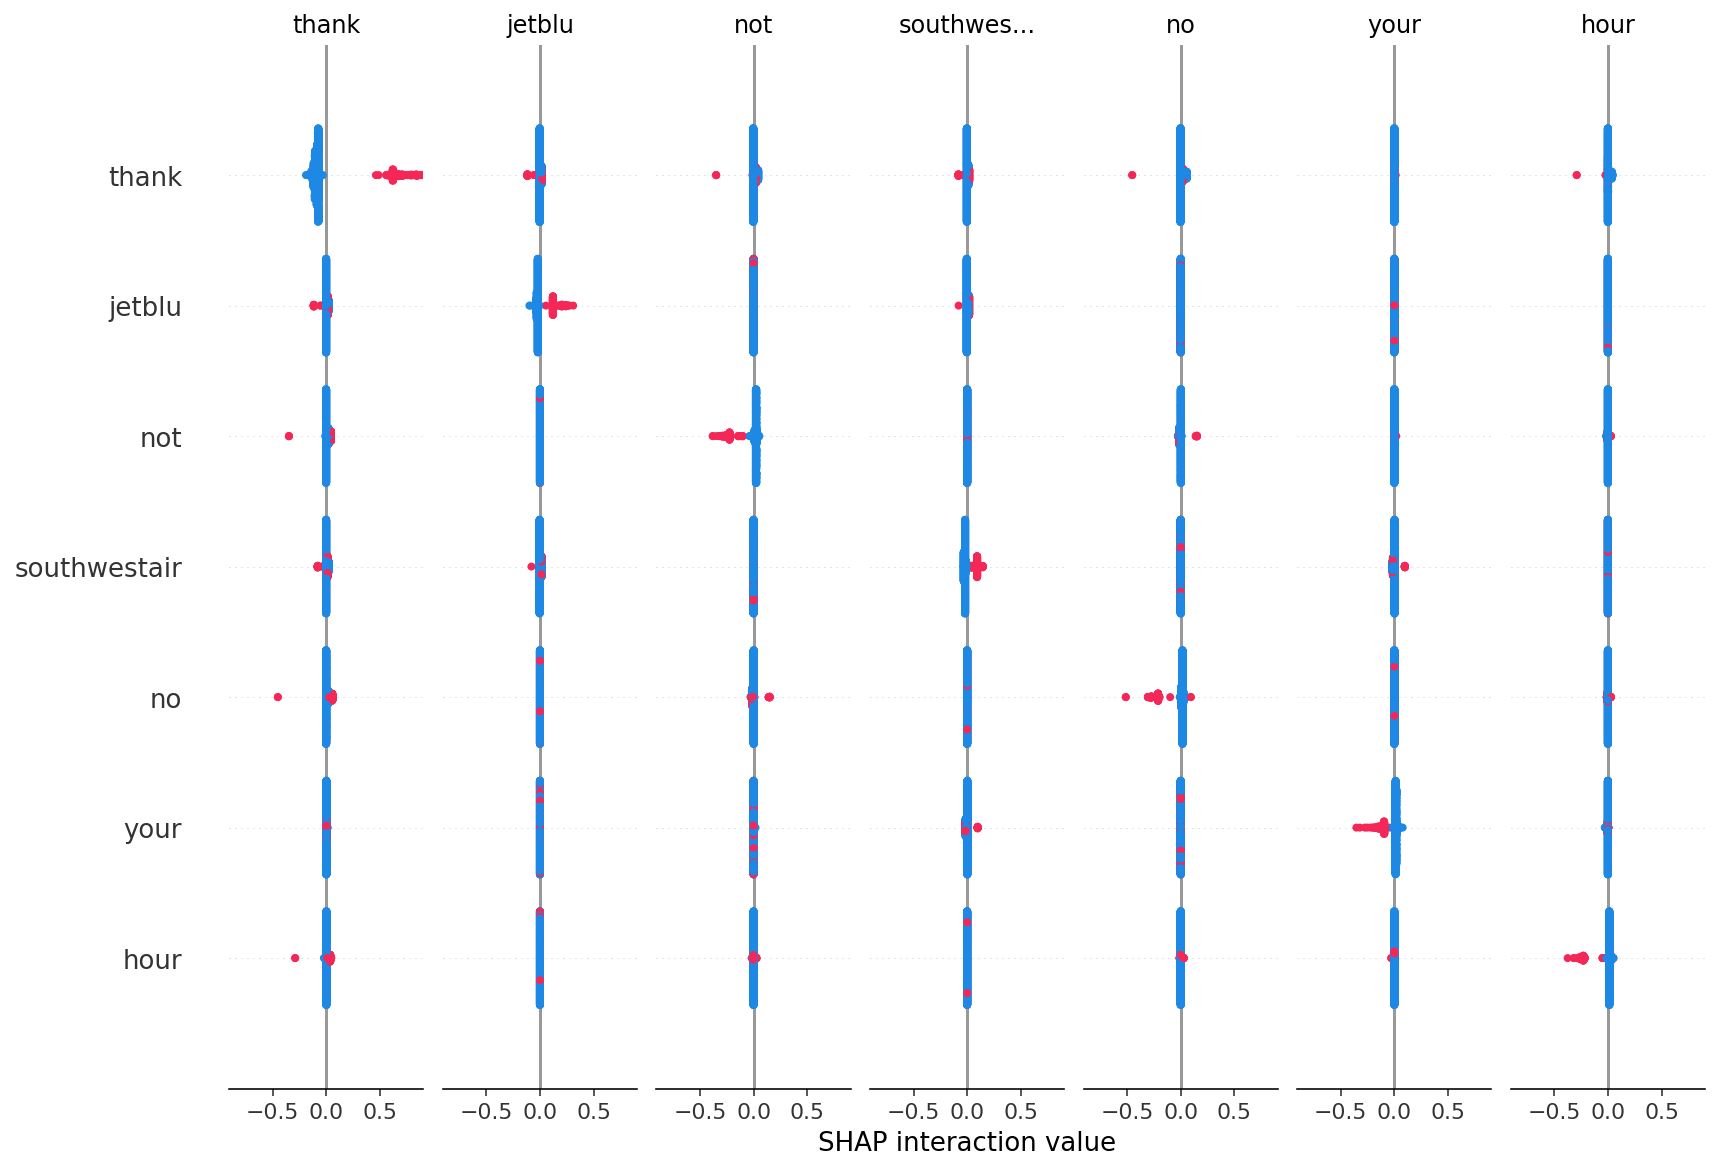

In [34]:
shap.summary_plot(shap_interaction_values, X_test.iloc[:1000,:])

In [40]:
import time
start = time.time()
shap_interaction_values = model.predict(xgboost.DMatrix(X.iloc[:1000,:]), pred_interactions=True)
time.time() - start

165.69956398010254